In [7]:
import torch
from transformers.models.gpt2 import GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
import transformers
from transformers import AutoTokenizer
from dataset import GPT2Dataset, GPT2DatasetReplace, TestDataset
from tqdm import tqdm
import numpy as np
import json
import re
import os

In [8]:
device = "cuda:0"
task = "add_ood"
cot = True
number = "a100_b100_3hole"

In [9]:
print("loading model...")
model_name = "gpt2"
if cot:
    model = GPT2LMHeadModel.from_pretrained(f"save_model_{model_name}/{task}/{number}_cot/model_99").to(device)
else:
    model = GPT2LMHeadModel.from_pretrained(f"save_model_{model_name}/{task}/{number}/model_99").to(device)
tokenizer = GPT2Tokenizer.from_pretrained("pretrained_models/gpt2")
print("done!")

loading model...
done!


In [10]:
if cot:
    file_path_test=f'datasets/{task}/{number}/test_cot.json'
    file_path_train=f'datasets/{task}/{number}/train_cot.json'
else:
    file_path_test=f'datasets/{task}/{number}/test.json'
    file_path_train=f'datasets/{task}/{number}/train.json'

with open(file_path_test, "r") as f:
    test_set = json.load(f)

with open(file_path_train, "r") as f:
    train_set = json.load(f)

In [11]:
def extract_answer(s: str):
    return re.findall(r'[0-9]+\.?[0-9]*', s)[-1]

# def extract_answer_cot(rationale):
#     try:
#         answer = rationale.split("\n")[-1].split(",")[1]
#     except:
#         answer = re.findall(r'[0-9]+\.?[0-9]*', rationale)[-1]
#     return answer

def generate(test_set, model, temperature=1, generation_num=1):
    '''
    return a list of dict [{
        "question":, "a":, "b":, "answers":[], "generated_answers":[], "acc":
    }]
    '''
    with torch.no_grad():
        model.eval()
    generated_samples = []
    for sample in tqdm(test_set):
        query = tokenizer(sample["question"], return_tensors="pt").input_ids
        if cot:
            answer = sample["gt"]
        else:
            answer = sample["answers"][0]
        generated_answers = []
        correct = 0
        all = 0
        for _ in range(generation_num):
            outputs = model.generate(query.to(device), max_length=50, do_sample=True, temperature=temperature, pad_token_id=50257)
            rationale = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
            # if cot:
            #     generated_answer = extract_answer_cot(generated_answer)
            # else:
            generated_answer = extract_answer(rationale)
            generated_answers.append(generated_answer)
            all += 1
            if generated_answer == answer:
                correct += 1
        sample["generated_answers"] = generated_answers
        sample["accuracy"] = correct / all
        generated_samples.append(sample)
        if correct == 0:
            print(rationale)
    return generated_samples

In [12]:
dataset = test_set
results = generate(dataset, model)

 28%|██▊       | 356/1259 [01:42<04:02,  3.72it/s]

18+21=18+21,,C:0
1+2,9,C:0
+,29,C:0
29


 28%|██▊       | 357/1259 [01:42<04:01,  3.74it/s]

18+22=18+22,,C:0
1+2,0,C:1
+,30,C:0
30


 28%|██▊       | 358/1259 [01:42<04:02,  3.71it/s]

18+23=18+23,,C:0
1+2,1,C:1
+,31,C:0
31


 29%|██▉       | 364/1259 [01:44<04:14,  3.51it/s]

18+29=18+29,,C:0
1+2,7,C:1
+,37,C:0
37


 29%|██▉       | 371/1259 [01:46<04:11,  3.53it/s]

18+36=18+36,,C:0
1+3,4,C:1
+,64,C:0
64


 30%|███       | 381/1259 [01:49<04:17,  3.41it/s]

19+19=19+19,,C:0
1+1,8,C:1
+,28,C:0
28


 30%|███       | 382/1259 [01:49<04:13,  3.46it/s]

19+20=19+20,,C:0
1+2,9,C:0
+,29,C:0
29


 30%|███       | 383/1259 [01:49<04:18,  3.39it/s]

19+21=19+21,,C:0
1+2,0,C:1
+,30,C:0
30


 31%|███       | 384/1259 [01:50<04:19,  3.37it/s]

19+22=19+22,,C:0
1+2,1,C:1
+,31,C:0
31


 31%|███       | 385/1259 [01:50<04:20,  3.35it/s]

19+23=19+23,,C:0
1+2,2,C:1
+,32,C:0
32


 31%|███       | 386/1259 [01:50<04:16,  3.40it/s]

19+24=19+24,,C:0
1+2,3,C:1
+,33,C:0
33


 31%|███       | 387/1259 [01:51<04:14,  3.43it/s]

19+25=19+25,,C:0
1+2,4,C:1
+,34,C:0
34


 31%|███       | 389/1259 [01:51<04:21,  3.33it/s]

19+27=19+27,,C:0
1+2,6,C:1
+,36,C:0
36


 31%|███       | 390/1259 [01:51<04:16,  3.39it/s]

19+28=19+28,,C:0
1+2,7,C:1
+,37,C:0
37


 31%|███       | 391/1259 [01:52<04:25,  3.27it/s]

19+29=19+29,,C:0
1+2,8,C:1
+,38,C:0
38


 32%|███▏      | 408/1259 [01:57<04:10,  3.39it/s]

20+19=20+19,,C:0
2+1,9,C:0
+,29,C:0
29


 32%|███▏      | 409/1259 [01:57<04:18,  3.28it/s]

20+20=20+20,,C:0
2+2,0,C:0
+,30,C:0
30


 33%|███▎      | 410/1259 [01:57<04:13,  3.35it/s]

20+21=20+21,,C:0
2+2,1,C:0
+,31,C:0
31


 33%|███▎      | 411/1259 [01:58<04:13,  3.35it/s]

20+22=20+22,,C:0
2+2,2,C:0
+,32,C:0
32


 33%|███▎      | 412/1259 [01:58<04:08,  3.41it/s]

20+23=20+23,,C:0
2+2,3,C:0
+,33,C:0
33


 33%|███▎      | 413/1259 [01:58<04:09,  3.39it/s]

20+24=20+24,,C:0
2+2,4,C:0
+,34,C:0
34


 33%|███▎      | 414/1259 [01:59<04:05,  3.44it/s]

20+25=20+25,,C:0
2+2,5,C:0
+,35,C:0
35


 33%|███▎      | 415/1259 [01:59<04:06,  3.42it/s]

20+26=20+26,,C:0
2+2,6,C:0
+,36,C:0
36


 33%|███▎      | 416/1259 [01:59<04:03,  3.46it/s]

20+27=20+27,,C:0
2+2,7,C:0
+,37,C:0
37


 33%|███▎      | 417/1259 [01:59<04:15,  3.29it/s]

20+28=20+28,,C:0
2+2,8,C:0
+,58,C:0
58


 33%|███▎      | 418/1259 [02:00<04:09,  3.37it/s]

20+29=20+29,,C:0
2+2,9,C:0
+,59,C:0
59


 33%|███▎      | 419/1259 [02:00<04:11,  3.34it/s]

20+30=20+30,,C:0
2+3,0,C:0
+,60,C:0
60


 33%|███▎      | 420/1259 [02:00<04:15,  3.29it/s]

20+31=20+31,,C:0
2+3,1,C:0
+,61,C:0
61


 33%|███▎      | 421/1259 [02:01<04:23,  3.18it/s]

20+32=20+32,,C:0
2+3,2,C:0
+,62,C:0
62


 34%|███▍      | 434/1259 [02:04<03:55,  3.51it/s]

21+18=21+18,,C:0
2+1,9,C:0
+,29,C:0
29


 35%|███▍      | 435/1259 [02:05<03:57,  3.47it/s]

21+19=21+19,,C:0
2+1,0,C:1
+,30,C:0
30


 35%|███▍      | 436/1259 [02:05<03:55,  3.50it/s]

21+20=21+20,,C:0
2+2,1,C:0
+,31,C:0
31


 35%|███▍      | 437/1259 [02:05<03:56,  3.48it/s]

21+21=21+21,,C:0
2+2,2,C:0
+,32,C:0
32


 35%|███▍      | 438/1259 [02:06<03:54,  3.50it/s]

21+22=21+22,,C:0
2+2,3,C:0
+,33,C:0
33


 35%|███▍      | 439/1259 [02:06<03:55,  3.48it/s]

21+23=21+23,,C:0
2+2,4,C:0
+,34,C:0
34


 35%|███▍      | 440/1259 [02:06<03:52,  3.52it/s]

21+24=21+24,,C:0
2+2,5,C:0
+,35,C:0
35


 35%|███▌      | 441/1259 [02:06<03:56,  3.46it/s]

21+25=21+25,,C:0
2+2,6,C:0
+,36,C:0
36


 35%|███▌      | 442/1259 [02:07<03:53,  3.50it/s]

21+26=21+26,,C:0
2+2,7,C:0
+,37,C:0
37


 35%|███▌      | 443/1259 [02:07<03:54,  3.48it/s]

21+27=21+27,,C:0
2+2,8,C:0
+,38,C:0
38


 35%|███▌      | 444/1259 [02:07<03:53,  3.48it/s]

21+28=21+28,,C:0
2+2,9,C:0
+,59,C:0
59


 35%|███▌      | 445/1259 [02:08<03:51,  3.52it/s]

21+29=21+29,,C:0
2+2,0,C:1
+,40,C:0
40


 35%|███▌      | 446/1259 [02:08<03:52,  3.50it/s]

21+30=21+30,,C:0
2+3,1,C:0
+,61,C:0
61


 36%|███▌      | 447/1259 [02:08<03:49,  3.53it/s]

21+31=21+31,,C:0
2+3,2,C:0
+,62,C:0
62


 37%|███▋      | 462/1259 [02:12<03:57,  3.36it/s]

22+19=22+19,,C:0
2+1,1,C:1
+,31,C:0
31


 37%|███▋      | 463/1259 [02:13<03:53,  3.41it/s]

22+20=22+20,,C:0
2+2,2,C:0
+,32,C:0
32


 37%|███▋      | 464/1259 [02:13<03:51,  3.43it/s]

22+21=22+21,,C:0
2+2,3,C:0
+,33,C:0
33


 37%|███▋      | 465/1259 [02:13<03:48,  3.47it/s]

22+22=22+22,,C:0
2+2,4,C:0
+,34,C:0
34


 37%|███▋      | 466/1259 [02:14<03:50,  3.44it/s]

22+23=22+23,,C:0
2+2,5,C:0
+,35,C:0
35


 37%|███▋      | 467/1259 [02:14<03:48,  3.47it/s]

22+24=22+24,,C:0
2+2,6,C:0
+,36,C:0
36


 37%|███▋      | 468/1259 [02:14<03:49,  3.44it/s]

22+25=22+25,,C:0
2+2,7,C:0
+,37,C:0
37


 37%|███▋      | 469/1259 [02:14<03:55,  3.35it/s]

22+26=22+26,,C:0
2+2,8,C:0
+,38,C:0
38


 37%|███▋      | 470/1259 [02:15<03:55,  3.36it/s]

22+27=22+27,,C:0
2+2,9,C:0
+,39,C:0
39


 37%|███▋      | 471/1259 [02:15<03:51,  3.41it/s]

22+28=22+28,,C:0
2+2,0,C:1
+,60,C:0
60


 37%|███▋      | 472/1259 [02:15<04:00,  3.27it/s]

22+29=22+29,,C:0
2+2,1,C:1
+,41,C:0
41


 38%|███▊      | 473/1259 [02:16<03:55,  3.34it/s]

22+30=22+30,,C:0
2+3,2,C:0
+,62,C:0
62


 39%|███▉      | 489/1259 [02:20<03:44,  3.43it/s]

23+19=23+19,,C:0
2+1,2,C:1
+,32,C:0
32


 39%|███▉      | 490/1259 [02:21<03:48,  3.37it/s]

23+20=23+20,,C:0
2+2,3,C:0
+,33,C:0
33


 39%|███▉      | 491/1259 [02:21<03:44,  3.42it/s]

23+21=23+21,,C:0
2+2,4,C:0
+,34,C:0
34


 39%|███▉      | 492/1259 [02:21<03:42,  3.45it/s]

23+22=23+22,,C:0
2+2,5,C:0
+,35,C:0
35


 39%|███▉      | 493/1259 [02:22<03:32,  3.60it/s]

23+23=23+23,,C:0
2+2,6,C:0
+,36,C:0
36


 39%|███▉      | 494/1259 [02:22<03:33,  3.59it/s]

23+24=23+24,,C:0
2+2,7,C:0
+,37,C:0
37


 39%|███▉      | 495/1259 [02:22<03:36,  3.53it/s]

23+25=23+25,,C:0
2+2,8,C:0
+,38,C:0
38


 39%|███▉      | 496/1259 [02:22<03:42,  3.43it/s]

23+26=23+26,,C:0
2+2,9,C:0
+,39,C:0
39


 39%|███▉      | 497/1259 [02:23<03:48,  3.34it/s]

23+27=23+27,,C:0
2+2,0,C:1
+,40,C:0
40


 40%|███▉      | 498/1259 [02:23<03:44,  3.40it/s]

23+28=23+28,,C:0
2+2,1,C:1
+,41,C:0
41


 40%|███▉      | 499/1259 [02:23<03:52,  3.27it/s]

23+29=23+29,,C:0
2+2,2,C:1
+,62,C:0
62


 41%|████      | 516/1259 [02:28<03:33,  3.48it/s]

24+19=24+19,,C:0
2+1,3,C:1
+,33,C:0
33


 41%|████      | 517/1259 [02:28<03:33,  3.47it/s]

24+20=24+20,,C:0
2+2,4,C:0
+,34,C:0
34


 41%|████      | 518/1259 [02:29<03:42,  3.33it/s]

24+21=24+21,,C:0
2+2,5,C:0
+,35,C:0
35


 41%|████      | 519/1259 [02:29<03:42,  3.32it/s]

24+22=24+22,,C:0
2+2,6,C:0
+,36,C:0
36


 41%|████▏     | 520/1259 [02:29<03:37,  3.39it/s]

24+23=24+23,,C:0
2+2,7,C:0
+,37,C:0
37


 41%|████▏     | 521/1259 [02:30<03:44,  3.29it/s]

24+24=24+24,,C:0
2+2,8,C:0
+,38,C:0
38


 41%|████▏     | 522/1259 [02:30<03:46,  3.26it/s]

24+25=24+25,,C:0
2+2,9,C:0
+,39,C:0
39


 42%|████▏     | 523/1259 [02:30<03:45,  3.26it/s]

24+26=24+26,,C:0
2+2,0,C:1
+,40,C:0
40


 42%|████▏     | 524/1259 [02:31<03:41,  3.32it/s]

24+27=24+27,,C:0
2+2,1,C:1
+,41,C:0
41


 42%|████▏     | 525/1259 [02:31<03:45,  3.25it/s]

24+28=24+28,,C:0
2+2,2,C:1
+,62,C:0
62


 42%|████▏     | 526/1259 [02:31<03:37,  3.38it/s]

24+29=24+29,,C:0
2+2,3,C:1
+,63,C:0
63


 42%|████▏     | 527/1259 [02:32<03:40,  3.32it/s]

24+30=24+30,,C:0
2+3,4,C:0
+,64,C:0
64


 42%|████▏     | 528/1259 [02:32<03:34,  3.40it/s]

24+31=24+31,,C:0
2+3,5,C:0
+,65,C:0
65


 43%|████▎     | 543/1259 [02:36<03:27,  3.46it/s]

25+19=25+19,,C:0
2+1,4,C:1
+,34,C:0
34


 43%|████▎     | 544/1259 [02:36<03:34,  3.34it/s]

25+20=25+20,,C:0
2+2,5,C:0
+,35,C:0
35


 43%|████▎     | 545/1259 [02:37<03:34,  3.33it/s]

25+21=25+21,,C:0
2+2,6,C:0
+,36,C:0
36


 43%|████▎     | 546/1259 [02:37<03:33,  3.35it/s]

25+22=25+22,,C:0
2+2,7,C:0
+,37,C:0
37


 43%|████▎     | 547/1259 [02:37<03:31,  3.37it/s]

25+23=25+23,,C:0
2+2,8,C:0
+,38,C:0
38


 44%|████▎     | 548/1259 [02:38<03:27,  3.43it/s]

25+24=25+24,,C:0
2+2,9,C:0
+,39,C:0
39


 44%|████▎     | 549/1259 [02:38<03:32,  3.35it/s]

25+25=25+25,,C:0
2+2,0,C:1
+,60,C:0
60


 44%|████▎     | 550/1259 [02:38<03:33,  3.32it/s]

25+26=25+26,,C:0
2+2,1,C:1
+,61,C:0
61


 44%|████▍     | 551/1259 [02:39<03:32,  3.34it/s]

25+27=25+27,,C:0
2+2,2,C:1
+,62,C:0
62


 44%|████▍     | 552/1259 [02:39<03:35,  3.29it/s]

25+28=25+28,,C:0
2+2,3,C:1
+,63,C:0
63


 44%|████▍     | 553/1259 [02:39<03:35,  3.28it/s]

25+29=25+29,,C:0
2+2,4,C:1
+,64,C:0
64


 44%|████▍     | 554/1259 [02:39<03:30,  3.35it/s]

25+30=25+30,,C:0
2+3,5,C:0
+,65,C:0
65


 44%|████▍     | 555/1259 [02:40<03:28,  3.38it/s]

25+31=25+31,,C:0
2+3,6,C:0
+,66,C:0
66


 45%|████▌     | 571/1259 [02:44<03:24,  3.36it/s]

26+20=26+20,,C:0
2+2,6,C:0
+,36,C:0
36


 45%|████▌     | 572/1259 [02:45<03:20,  3.43it/s]

26+21=26+21,,C:0
2+2,7,C:0
+,37,C:0
37


 46%|████▌     | 573/1259 [02:45<03:26,  3.32it/s]

26+22=26+22,,C:0
2+2,8,C:0
+,38,C:0
38


 46%|████▌     | 574/1259 [02:45<03:22,  3.38it/s]

26+23=26+23,,C:0
2+2,9,C:0
+,39,C:0
39


 46%|████▌     | 575/1259 [02:46<03:21,  3.40it/s]

26+24=26+24,,C:0
2+2,0,C:1
+,40,C:0
40


 46%|████▌     | 576/1259 [02:46<03:18,  3.45it/s]

26+25=26+25,,C:0
2+2,1,C:1
+,41,C:0
41


 46%|████▌     | 577/1259 [02:46<03:18,  3.44it/s]

26+26=26+26,,C:0
2+2,2,C:1
+,62,C:0
62


 46%|████▌     | 578/1259 [02:47<03:15,  3.48it/s]

26+27=26+27,,C:0
2+2,3,C:1
+,63,C:0
63


 46%|████▌     | 579/1259 [02:47<03:18,  3.42it/s]

26+28=26+28,,C:0
2+2,4,C:1
+,64,C:0
64


 46%|████▌     | 580/1259 [02:47<03:16,  3.45it/s]

26+29=26+29,,C:0
2+2,5,C:1
+,65,C:0
65


 46%|████▌     | 581/1259 [02:47<03:18,  3.41it/s]

26+30=26+30,,C:0
2+3,6,C:0
+,66,C:0
66


 46%|████▌     | 582/1259 [02:48<03:16,  3.44it/s]

26+31=26+31,,C:0
2+3,7,C:0
+,67,C:0
67


 47%|████▋     | 597/1259 [02:52<03:09,  3.48it/s]

27+19=27+19,,C:0
2+1,6,C:1
+,36,C:0
36


 47%|████▋     | 598/1259 [02:52<03:08,  3.51it/s]

27+20=27+20,,C:0
2+2,7,C:0
+,37,C:0
37


 48%|████▊     | 599/1259 [02:53<03:09,  3.48it/s]

27+21=27+21,,C:0
2+2,8,C:0
+,38,C:0
38


 48%|████▊     | 600/1259 [02:53<03:14,  3.38it/s]

27+22=27+22,,C:0
2+2,9,C:0
+,39,C:0
39


 48%|████▊     | 601/1259 [02:53<03:16,  3.34it/s]

27+23=27+23,,C:0
2+2,0,C:1
+,40,C:0
40


 48%|████▊     | 602/1259 [02:54<03:13,  3.40it/s]

27+24=27+24,,C:0
2+2,1,C:1
+,41,C:0
41


 48%|████▊     | 603/1259 [02:54<03:16,  3.34it/s]

27+25=27+25,,C:0
2+2,2,C:1
+,62,C:0
62


 48%|████▊     | 604/1259 [02:54<03:18,  3.30it/s]

27+26=27+26,,C:0
2+2,3,C:1
+,63,C:0
63


 48%|████▊     | 605/1259 [02:54<03:21,  3.24it/s]

27+27=27+27,,C:0
2+2,4,C:1
+,64,C:0
64


 48%|████▊     | 606/1259 [02:55<03:14,  3.36it/s]

27+28=27+28,,C:0
2+2,5,C:1
+,65,C:0
65


 48%|████▊     | 607/1259 [02:55<03:14,  3.35it/s]

27+29=27+29,,C:0
2+2,6,C:1
+,66,C:0
66


 48%|████▊     | 608/1259 [02:55<03:10,  3.42it/s]

27+30=27+30,,C:0
2+3,7,C:0
+,67,C:0
67


 50%|████▉     | 624/1259 [03:00<03:02,  3.47it/s]

28+19=28+19,,C:0
2+1,7,C:1
+,37,C:0
37


 50%|████▉     | 626/1259 [03:01<03:06,  3.40it/s]

28+21=28+21,,C:0
2+2,9,C:0
+,39,C:0
39


 50%|████▉     | 627/1259 [03:01<03:03,  3.44it/s]

28+22=28+22,,C:0
2+2,0,C:1
+,40,C:0
40


 50%|████▉     | 628/1259 [03:01<02:55,  3.60it/s]

28+23=28+23,,C:0
2+2,1,C:1
+,41,C:0
41


 50%|████▉     | 629/1259 [03:01<02:59,  3.52it/s]

28+24=28+24,,C:0
2+2,2,C:1
+,42,C:0
42


 50%|█████     | 630/1259 [03:02<02:58,  3.52it/s]

28+25=28+25,,C:0
2+2,3,C:1
+,63,C:0
63


 50%|█████     | 631/1259 [03:02<02:59,  3.49it/s]

28+26=28+26,,C:0
2+2,4,C:1
+,64,C:0
64


 50%|█████     | 632/1259 [03:02<02:59,  3.50it/s]

28+27=28+27,,C:0
2+2,5,C:1
+,65,C:0
65


 50%|█████     | 633/1259 [03:03<03:00,  3.47it/s]

28+28=28+28,,C:0
2+2,6,C:1
+,66,C:0
66


 50%|█████     | 634/1259 [03:03<03:06,  3.35it/s]

28+29=28+29,,C:0
2+2,7,C:1
+,67,C:0
67


 50%|█████     | 635/1259 [03:03<03:04,  3.39it/s]

28+30=28+30,,C:0
2+3,8,C:0
+,68,C:0
68


 51%|█████     | 636/1259 [03:03<03:02,  3.41it/s]

28+31=28+31,,C:0
2+3,9,C:0
+,69,C:0
69


 52%|█████▏    | 651/1259 [03:08<03:00,  3.37it/s]

29+19=29+19,,C:0
2+1,8,C:1
+,38,C:0
38


 52%|█████▏    | 652/1259 [03:08<02:57,  3.42it/s]

29+20=29+20,,C:0
2+2,9,C:0
+,39,C:0
39


 52%|█████▏    | 653/1259 [03:08<02:58,  3.40it/s]

29+21=29+21,,C:0
2+2,0,C:1
+,40,C:0
40


 52%|█████▏    | 654/1259 [03:09<02:55,  3.44it/s]

29+22=29+22,,C:0
2+2,1,C:1
+,41,C:0
41


 52%|█████▏    | 655/1259 [03:09<02:57,  3.41it/s]

29+23=29+23,,C:0
2+2,2,C:1
+,42,C:0
42


 52%|█████▏    | 656/1259 [03:09<02:54,  3.45it/s]

29+24=29+24,,C:0
2+2,3,C:1
+,63,C:0
63


 52%|█████▏    | 657/1259 [03:10<03:00,  3.33it/s]

29+25=29+25,,C:0
2+2,4,C:1
+,64,C:0
64


 52%|█████▏    | 658/1259 [03:10<02:57,  3.39it/s]

29+26=29+26,,C:0
2+2,5,C:1
+,65,C:0
65


 52%|█████▏    | 659/1259 [03:10<02:57,  3.39it/s]

29+27=29+27,,C:0
2+2,6,C:1
+,66,C:0
66


 52%|█████▏    | 660/1259 [03:10<02:54,  3.43it/s]

29+28=29+28,,C:0
2+2,7,C:1
+,67,C:0
67


 53%|█████▎    | 661/1259 [03:11<02:54,  3.43it/s]

29+29=29+29,,C:0
2+2,8,C:1
+,68,C:0
68


 53%|█████▎    | 662/1259 [03:11<02:52,  3.45it/s]

29+30=29+30,,C:0
2+3,9,C:0
+,69,C:0
69


 59%|█████▉    | 742/1259 [03:34<02:40,  3.23it/s]

49+48=49+48,,C:0
4+4,7,C:1
+,07,C:1
+,107,C:0
107


 75%|███████▍  | 943/1259 [04:40<01:53,  2.79it/s]

73+74=73+74,,C:0
7+7,7,C:0
+,37,C:1
+,137,C:0
137


 75%|███████▍  | 944/1259 [04:40<01:54,  2.76it/s]

73+75=73+75,,C:0
7+7,8,C:0
+,38,C:1
+,138,C:0
138


 76%|███████▋  | 961/1259 [04:47<01:48,  2.76it/s]

74+73=74+73,,C:0
7+7,7,C:0
+,37,C:1
+,137,C:0
137


 76%|███████▋  | 962/1259 [04:47<01:46,  2.78it/s]

74+74=74+74,,C:0
7+7,8,C:0
+,38,C:1
+,138,C:0
138


 76%|███████▋  | 963/1259 [04:47<01:46,  2.77it/s]

74+75=74+75,,C:0
7+7,9,C:0
+,39,C:1
+,139,C:0
139


 77%|███████▋  | 964/1259 [04:48<01:45,  2.79it/s]

74+76=74+76,,C:0
7+7,0,C:1
+,40,C:1
+,140,C:0
140


 78%|███████▊  | 980/1259 [04:53<01:41,  2.74it/s]

75+73=75+73,,C:0
7+7,8,C:0
+,38,C:1
+,138,C:0
138


 78%|███████▊  | 982/1259 [04:54<01:41,  2.74it/s]

75+75=75+75,,C:0
7+7,0,C:1
+,40,C:1
+,140,C:0
140


 78%|███████▊  | 983/1259 [04:55<01:41,  2.72it/s]

75+76=75+76,,C:0
7+7,1,C:1
+,41,C:1
+,141,C:0
141


 78%|███████▊  | 986/1259 [04:56<01:39,  2.74it/s]

75+79=75+79,,C:0
7+7,4,C:1
+,64,C:1
+,164,C:0
164


 78%|███████▊  | 987/1259 [04:56<01:38,  2.77it/s]

75+80=75+80,,C:0
7+8,5,C:0
+,65,C:1
+,165,C:0
165


 78%|███████▊  | 988/1259 [04:56<01:40,  2.69it/s]

75+81=75+81,,C:0
7+8,6,C:0
+,66,C:1
+,166,C:0
166


 79%|███████▉  | 999/1259 [05:00<01:37,  2.66it/s]

76+73=76+73,,C:0
7+7,9,C:0
+,39,C:1
+,139,C:0
139


 79%|███████▉  | 1000/1259 [05:01<01:37,  2.67it/s]

76+74=76+74,,C:0
7+7,0,C:1
+,40,C:1
+,140,C:0
140


 80%|███████▉  | 1001/1259 [05:01<01:31,  2.82it/s]

76+75=76+75,,C:0
7+7,1,C:1
+,41,C:1
+,141,C:0
141


 80%|███████▉  | 1002/1259 [05:02<01:33,  2.76it/s]

76+76=76+76,,C:0
7+7,2,C:1
+,62,C:1
+,162,C:0
162


 80%|███████▉  | 1003/1259 [05:02<01:34,  2.72it/s]

76+77=76+77,,C:0
7+7,3,C:1
+,63,C:1
+,163,C:0
163


 80%|███████▉  | 1004/1259 [05:02<01:36,  2.65it/s]

76+78=76+78,,C:0
7+7,4,C:1
+,64,C:1
+,164,C:0
164


 80%|███████▉  | 1005/1259 [05:03<01:35,  2.67it/s]

76+79=76+79,,C:0
7+7,5,C:1
+,65,C:1
+,165,C:0
165


 80%|███████▉  | 1006/1259 [05:03<01:34,  2.69it/s]

76+80=76+80,,C:0
7+8,6,C:0
+,66,C:1
+,166,C:0
166


 81%|████████  | 1020/1259 [05:08<01:31,  2.62it/s]

77+75=77+75,,C:0
7+7,2,C:1
+,62,C:1
+,162,C:0
162


 81%|████████  | 1021/1259 [05:09<01:28,  2.68it/s]

77+76=77+76,,C:0
7+7,3,C:1
+,63,C:1
+,163,C:0
163


 81%|████████  | 1022/1259 [05:09<01:30,  2.61it/s]

77+77=77+77,,C:0
7+7,4,C:1
+,64,C:1
+,164,C:0
164


 81%|████████▏ | 1023/1259 [05:09<01:29,  2.65it/s]

77+78=77+78,,C:0
7+7,5,C:1
+,65,C:1
+,165,C:0
165


 81%|████████▏ | 1024/1259 [05:10<01:26,  2.71it/s]

77+79=77+79,,C:0
7+7,6,C:1
+,66,C:1
+,166,C:0
166


 81%|████████▏ | 1025/1259 [05:10<01:26,  2.71it/s]

77+80=77+80,,C:0
7+8,7,C:0
+,67,C:1
+,167,C:0
167


 81%|████████▏ | 1026/1259 [05:10<01:24,  2.75it/s]

77+81=77+81,,C:0
7+8,8,C:0
+,68,C:1
+,168,C:0
168


 82%|████████▏ | 1027/1259 [05:11<01:24,  2.73it/s]

77+82=77+82,,C:0
7+8,9,C:0
+,69,C:1
+,169,C:0
169


 82%|████████▏ | 1028/1259 [05:11<01:26,  2.66it/s]

77+83=77+83,,C:0
7+8,0,C:1
+,70,C:1
+,170,C:0
170


 82%|████████▏ | 1038/1259 [05:15<01:18,  2.81it/s]

78+74=78+74,,C:0
7+7,2,C:1
+,62,C:1
+,162,C:0
162


 83%|████████▎ | 1040/1259 [05:15<01:18,  2.80it/s]

78+76=78+76,,C:0
7+7,4,C:1
+,64,C:1
+,164,C:0
164


 83%|████████▎ | 1041/1259 [05:16<01:18,  2.78it/s]

78+77=78+77,,C:0
7+7,5,C:1
+,65,C:1
+,165,C:0
165


 83%|████████▎ | 1042/1259 [05:16<01:18,  2.76it/s]

78+78=78+78,,C:0
7+7,6,C:1
+,66,C:1
+,166,C:0
166


 83%|████████▎ | 1043/1259 [05:17<01:18,  2.75it/s]

78+79=78+79,,C:0
7+7,7,C:1
+,67,C:1
+,167,C:0
167


 83%|████████▎ | 1044/1259 [05:17<01:17,  2.78it/s]

78+80=78+80,,C:0
7+8,8,C:0
+,68,C:1
+,168,C:0
168


 83%|████████▎ | 1046/1259 [05:18<01:18,  2.71it/s]

78+82=78+82,,C:0
7+8,0,C:1
+,70,C:1
+,170,C:0
170


 84%|████████▍ | 1058/1259 [05:22<01:14,  2.69it/s]

79+75=79+75,,C:0
7+7,4,C:1
+,64,C:1
+,164,C:0
164


 84%|████████▍ | 1059/1259 [05:22<01:14,  2.68it/s]

79+76=79+76,,C:0
7+7,5,C:1
+,65,C:1
+,165,C:0
165


 84%|████████▍ | 1060/1259 [05:23<01:13,  2.72it/s]

79+77=79+77,,C:0
7+7,6,C:1
+,66,C:1
+,166,C:0
166


 84%|████████▍ | 1061/1259 [05:23<01:14,  2.66it/s]

79+78=79+78,,C:0
7+7,7,C:1
+,67,C:1
+,167,C:0
167


 84%|████████▍ | 1062/1259 [05:23<01:13,  2.70it/s]

79+79=79+79,,C:0
7+7,8,C:1
+,68,C:1
+,168,C:0
168


 84%|████████▍ | 1063/1259 [05:24<01:12,  2.72it/s]

79+80=79+80,,C:0
7+8,9,C:0
+,69,C:1
+,169,C:0
169


 85%|████████▍ | 1064/1259 [05:24<01:11,  2.72it/s]

79+81=79+81,,C:0
7+8,0,C:1
+,70,C:1
+,170,C:0
170


 85%|████████▍ | 1067/1259 [05:25<01:10,  2.71it/s]

79+84=79+84,,C:0
7+8,3,C:1
+,73,C:1
+,173,C:0
173


 86%|████████▌ | 1078/1259 [05:29<01:05,  2.78it/s]

80+76=80+76,,C:0
8+7,6,C:0
+,66,C:1
+,166,C:0
166


 86%|████████▌ | 1079/1259 [05:30<01:05,  2.76it/s]

80+77=80+77,,C:0
8+7,7,C:0
+,67,C:1
+,167,C:0
167


 86%|████████▌ | 1080/1259 [05:30<01:05,  2.75it/s]

80+78=80+78,,C:0
8+7,8,C:0
+,68,C:1
+,168,C:0
168


 86%|████████▌ | 1081/1259 [05:30<01:04,  2.75it/s]

80+79=80+79,,C:0
8+7,9,C:0
+,69,C:1
+,169,C:0
169


 86%|████████▌ | 1082/1259 [05:31<01:04,  2.72it/s]

80+80=80+80,,C:0
8+8,0,C:0
+,70,C:1
+,170,C:0
170


 86%|████████▌ | 1083/1259 [05:31<01:03,  2.76it/s]

80+81=80+81,,C:0
8+8,1,C:0
+,71,C:1
+,171,C:0
171


 86%|████████▌ | 1084/1259 [05:32<01:06,  2.65it/s]

80+82=80+82,,C:0
8+8,2,C:0
+,72,C:1
+,172,C:0
172


 86%|████████▌ | 1085/1259 [05:32<01:04,  2.68it/s]

80+83=80+83,,C:0
8+8,3,C:0
+,73,C:1
+,173,C:0
173


 87%|████████▋ | 1097/1259 [05:36<00:59,  2.74it/s]

81+76=81+76,,C:0
8+7,7,C:0
+,67,C:1
+,167,C:0
167


 87%|████████▋ | 1098/1259 [05:37<00:57,  2.80it/s]

81+77=81+77,,C:0
8+7,8,C:0
+,68,C:1
+,168,C:0
168


 87%|████████▋ | 1099/1259 [05:37<00:55,  2.91it/s]

81+78=81+78,,C:0
8+7,9,C:0
+,69,C:1
+,169,C:0
169


 87%|████████▋ | 1100/1259 [05:37<00:55,  2.87it/s]

81+79=81+79,,C:0
8+7,0,C:1
+,70,C:1
+,170,C:0
170


 87%|████████▋ | 1101/1259 [05:38<00:55,  2.87it/s]

81+80=81+80,,C:0
8+8,1,C:0
+,71,C:1
+,171,C:0
171


 88%|████████▊ | 1102/1259 [05:38<00:56,  2.79it/s]

81+81=81+81,,C:0
8+8,2,C:0
+,72,C:1
+,172,C:0
172


 88%|████████▊ | 1103/1259 [05:38<00:56,  2.76it/s]

81+82=81+82,,C:0
8+8,3,C:0
+,73,C:1
+,173,C:0
173


 88%|████████▊ | 1104/1259 [05:39<00:55,  2.78it/s]

81+83=81+83,,C:0
8+8,4,C:0
+,74,C:1
+,174,C:0
174


 88%|████████▊ | 1105/1259 [05:39<00:55,  2.76it/s]

81+84=81+84,,C:0
8+8,5,C:0
+,75,C:1
+,175,C:0
175


 89%|████████▊ | 1117/1259 [05:44<00:51,  2.77it/s]

82+77=82+77,,C:0
8+7,9,C:0
+,69,C:1
+,169,C:0
169


 89%|████████▉ | 1119/1259 [05:44<00:50,  2.75it/s]

82+79=82+79,,C:0
8+7,1,C:1
+,71,C:1
+,171,C:0
171


 89%|████████▉ | 1120/1259 [05:45<00:51,  2.72it/s]

82+80=82+80,,C:0
8+8,2,C:0
+,72,C:1
+,172,C:0
172


 89%|████████▉ | 1121/1259 [05:45<00:50,  2.75it/s]

82+81=82+81,,C:0
8+8,3,C:0
+,73,C:1
+,173,C:0
173


 89%|████████▉ | 1122/1259 [05:45<00:49,  2.75it/s]

82+82=82+82,,C:0
8+8,4,C:0
+,74,C:1
+,174,C:0
174


 90%|█████████ | 1136/1259 [05:50<00:45,  2.68it/s]

83+77=83+77,,C:0
8+7,0,C:1
+,70,C:1
+,170,C:0
170


 90%|█████████ | 1137/1259 [05:51<00:45,  2.69it/s]

83+78=83+78,,C:0
8+7,1,C:1
+,71,C:1
+,171,C:0
171


 90%|█████████ | 1139/1259 [05:52<00:43,  2.74it/s]

83+80=83+80,,C:0
8+8,3,C:0
+,73,C:1
+,173,C:0
173


 91%|█████████ | 1140/1259 [05:52<00:44,  2.68it/s]

83+81=83+81,,C:0
8+8,4,C:0
+,74,C:1
+,174,C:0
174


 92%|█████████▏| 1157/1259 [05:58<00:36,  2.77it/s]

84+79=84+79,,C:0
8+7,3,C:1
+,73,C:1
+,173,C:0
173


 92%|█████████▏| 1158/1259 [05:59<00:36,  2.75it/s]

84+80=84+80,,C:0
8+8,4,C:0
+,74,C:1
+,174,C:0
174


 92%|█████████▏| 1159/1259 [05:59<00:36,  2.76it/s]

84+81=84+81,,C:0
8+8,5,C:0
+,75,C:1
+,175,C:0
175


 92%|█████████▏| 1160/1259 [05:59<00:36,  2.74it/s]

84+82=84+82,,C:0
8+8,6,C:0
+,76,C:1
+,176,C:0
176


 92%|█████████▏| 1161/1259 [06:00<00:35,  2.74it/s]

84+83=84+83,,C:0
8+8,7,C:0
+,77,C:1
+,177,C:0
177


 92%|█████████▏| 1162/1259 [06:00<00:35,  2.77it/s]

84+84=84+84,,C:0
8+8,8,C:0
+,78,C:1
+,178,C:0
178


 94%|█████████▎| 1178/1259 [06:06<00:29,  2.73it/s]

85+81=85+81,,C:0
8+8,6,C:0
+,76,C:1
+,176,C:0
176


 94%|█████████▎| 1179/1259 [06:06<00:29,  2.74it/s]

85+82=85+82,,C:0
8+8,7,C:0
+,77,C:1
+,177,C:0
177


100%|██████████| 1259/1259 [06:35<00:00,  3.18it/s]


In [13]:
a_range = b_range = 100
data = np.zeros((a_range, b_range))
for result in results:
    a = int(result["a"])
    b = int(result["b"])
    data[a][b] = result["accuracy"]

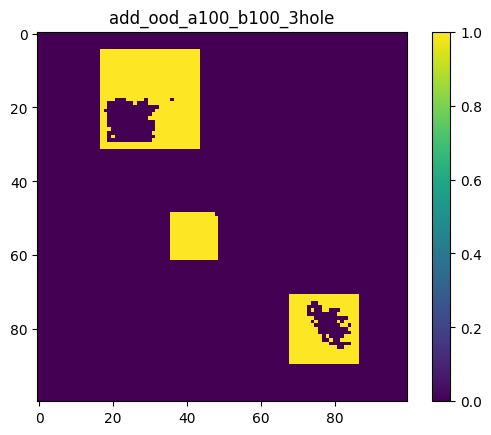

In [14]:
import matplotlib.pyplot as plt

plt.title(f"{task}_{number}")
plt.imshow(data)
plt.colorbar()
plt.savefig(f"save_model_{model_name}/{task}/{number}_cot/model_99/result.pdf")